In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import cupy as cp
import tensorflow as tf
import tensorflow_probability as tfp
import timeseriesanalysis as tsa
!pip install bezier
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
import itertools 
from scipy.special import comb
from scipy import signal

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import cupy as cp
import numpy as np
from scipy.special import comb
from tqdm import tqdm

def bezier_curve_fast_cupy(control_points, num_points=100):
    """
    Generates 2D Bézier curves for a batch of control point arrangements,
    optimized for speed using CuPy, and scales each curve so that its points sum to 1.

    Args:
        control_points (cupy array): A CuPy array of shape (num_arrangements, n+1, 2)
            representing the control points for each Bézier curve.
        num_points (int): The number of points to generate along each curve.

    Returns:
        cupy array: A CuPy array of shape (num_arrangements, num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curves, scaled to sum to 1.
    """

    n = control_points.shape[1] - 1
    num_arrangements = control_points.shape[0]

    # Precompute Bernstein basis polynomials for all t values
    t = cp.linspace(0, 1, num_points)[:, None]

    # Precompute the binomial coefficients (on the CPU, then transfer)
    binomial_coefficients = np.array([comb(n, i) for i in range(n + 1)])
    binomial_coefficients_gpu = cp.asarray(binomial_coefficients)

    # Vectorized calculation of Bernstein polynomials
    bernstein_polynomials = binomial_coefficients_gpu * (t ** cp.arange(n + 1).reshape(1, -1)) * ((1 - t) ** cp.arange(n, -1, -1).reshape(1, -1))

    # Calculate curve points using vectorized operations (Batch Matrix Multiplication)
    points = cp.matmul(bernstein_polynomials, control_points)

    # Scale the curve to sum to 1
    curve_sum = cp.sum(points, axis=1, keepdims=True)
    mask = (curve_sum != 0)
    points = cp.where(mask, points / curve_sum, points)

    return points.astype(cp.float16)

def generate_coordinate_arrangements_cupy():
    """
    Generates all possible coordinate arrangements for four points, as a CuPy array.

    Returns:
        A CuPy array of shape (num_arrangements, 4, 2).
    """
    arrangements = []
    for y1 in range(0, 7):
        for x2 in range(0, 5):
            for y2 in range(0, 7):
                for x3 in range(0, 5):
                    for y3 in range(0, 7):
                        for y4 in range(0, 7):
                            point1 = [0, y1]
                            point2 = [x2, y2]
                            point3 = [x3, y3]
                            point4 = [4, y4]
                            arrangements.append(np.array([point1, point2, point3, point4]))

    return cp.asarray(arrangements)

# Generate all arrangements
all_arrangements_gpu = generate_coordinate_arrangements_cupy()

min_window_size = 10
max_window_size = 1000
window_size_step = 15
loop_points = range(min_window_size, max_window_size, window_size_step)
enum_loop_points = enumerate(loop_points)

# Preallocate the array to store the kernel functions (on the CPU)
kernel_functions = [] # Changed from np.empty to a list

with tqdm(desc="Processing") as pbar:
    for window_index, window_size in enum_loop_points:
        # Calculate all Bezier curves for the current window size in one go!
        all_curves = bezier_curve_fast_cupy(all_arrangements_gpu, num_points=window_size) #shape is num_arrangements, num_points, 2
        y_coords_gpu = all_curves[:, :, 1]  # Extract y-coordinates; shape is num_arrangements, num_points

        # Copy y-coordinates to CPU as a NumPy array
        y_coords_cpu = cp.asnumpy(y_coords_gpu)  #Shape is now num_arrangements, num_points

        #Store NumPy Array as a 2D array in the list.
        kernel_functions.append(y_coords_cpu) #Changed to append, not assign

        pbar.update(1)

Processing: 66it [00:07,  8.41it/s]


In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

tfd = tfp.distributions

def bezier_curve_fast_tf(control_points, num_points=100):
    """
    Generates 2D Bézier curves for a batch of control point arrangements,
    optimized for speed using TensorFlow and TPUs, and scales each curve so that its points sum to 1.

    Args:
        control_points (tf.Tensor): A TensorFlow tensor of shape (num_arrangements, n+1, 2)
            representing the control points for each Bézier curve.
        num_points (int): The number of points to generate along each curve.

    Returns:
        tf.Tensor: A TensorFlow tensor of shape (num_arrangements, num_points, 2) containing the (x, y)
            coordinates of the points on the Bézier curves, scaled to sum to 1.
    """

    n = tf.cast(tf.shape(control_points)[1] - 1, dtype=tf.float32)  # Use tf.cast
    num_arrangements = tf.shape(control_points)[0]

    # Precompute Bernstein basis polynomials for all t values
    t = tf.linspace(0.0, 1.0, num_points)[:, None]

    # Precompute the binomial coefficients (on the CPU, then transfer if needed - usually XLA handles this fine)
    binomial_coefficients = np.array([comb(int(n), i) for i in range(int(n) + 1)])
    binomial_coefficients_tf = tf.constant(binomial_coefficients, dtype=tf.float32) # Convert to tf.constant

    # Vectorized calculation of Bernstein polynomials
    arange_n_plus_1 = tf.range(int(n + 1), dtype=tf.float32)
    bernstein_polynomials = binomial_coefficients_tf * (t ** arange_n_plus_1) * ((1 - t) ** tf.reverse(arange_n_plus_1, axis=[0]))

    # Calculate curve points using vectorized operations (Batch Matrix Multiplication)
    bernstein_polynomials = tf.cast(bernstein_polynomials, dtype=tf.float32)
    control_points = tf.cast(control_points, dtype=tf.float32)
    points = tf.matmul(bernstein_polynomials, control_points)

    # Scale the curve to sum to 1
    curve_sum = tf.reduce_sum(points, axis=1, keepdims=True)
    mask = tf.not_equal(curve_sum, 0)
    points = tf.where(mask, points / curve_sum, points)

    return tf.cast(points, dtype=tf.float16)


def generate_coordinate_arrangements_tf():
    """
    Generates all possible coordinate arrangements for four points, as a TensorFlow tensor.

    Returns:
        A TensorFlow tensor of shape (num_arrangements, 4, 2).
    """
    arrangements = []
    for y1 in range(0, 7):
        for x2 in range(0, 5):
            for y2 in range(0, 7):
                for x3 in range(0, 5):
                    for y3 in range(0, 7):
                        for y4 in range(0, 7):
                            point1 = [0, y1]
                            point2 = [x2, y2]
                            point3 = [x3, y3]
                            point4 = [4, y4]
                            arrangements.append(np.array([point1, point2, point3, point4]))

    return tf.constant(np.array(arrangements), dtype=tf.float32)


# TPU Strategy Setup (REQUIRED if running on TPU)
# This part needs to be adjusted based on your specific TPU setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default strategy in case of no TPU

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Now, wrap everything that uses the TPU inside the strategy scope
with strategy.scope():
    # Generate all arrangements
    all_arrangements_tf = generate_coordinate_arrangements_tf()

    min_window_size = 10
    max_window_size = 1000
    window_size_step = 15
    loop_points = range(min_window_size, max_window_size, window_size_step)
    enum_loop_points = enumerate(loop_points)

    # Preallocate the array to store the kernel functions (on the CPU)
    kernel_functions = np.empty((len(loop_points), len(all_arrangements_tf)), dtype=object)


    with tqdm(desc="Processing") as pbar:
        for window_index, window_size in enum_loop_points:
            # Calculate all Bezier curves for the current window size in one go!
            all_curves = bezier_curve_fast_tf(all_arrangements_tf, num_points=window_size) #shape is num_arrangements, num_points, 2
            y_coords_tf = all_curves[:, :, 1]  # Extract y-coordinates; shape is num_arrangements, num_points

            # Convert y_coords_tf to NumPy array
            y_coords_np = y_coords_tf.numpy()

            # Store NumPy Array in 2d output.
            kernel_functions[window_index, :] = [y_coords_np[i, :] for i in range(y_coords_np.shape[0])]

            pbar.update(1)

print("Finished processing.")

REPLICAS:  1


Processing: 66it [00:14,  4.52it/s]


Finished processing.


In [2]:
def apply_kernel_filters(time_series, kernel_functions, padding='VALID', strides=1):
    """
    Applies a set of kernel functions to a 1D time series using tf.nn.conv1d.

    Args:
        time_series: A 1D numpy array representing the time series data.
        kernel_functions: A 2D numpy array where each row is a kernel function.  Shape (num_kernel_functions, kernel_length).
        padding:  String, either 'VALID' or 'SAME'.  Determines how the edges are handled.
        strides: int or a list/tuple of ints.  Stride of the convolution.  If an int is provided, it is used for all spatial dimensions.  Defaults to 1.

    Returns:
        A tensor with shape [1, out_width, num_kernel_functions], where out_width
        depends on the padding and stride.  We'll typically squeeze this to
        [out_width, num_kernel_functions].
    """

    # 1. Prepare the data for tf.nn.convolution
    time_series = np.expand_dims(time_series, axis=(0, -1))  # Shape: (1, time_series_length, 1)
    kernel_functions = np.expand_dims(kernel_functions, axis=1) # Shape: (num_kernel_functions, 1, kernel_length)
    kernel_functions = np.transpose(kernel_functions, (2, 1, 0)) # Shape: (kernel_length, 1, num_kernel_functions)


    time_series = tf.convert_to_tensor(time_series, dtype=tf.float32)
    kernel_functions = tf.convert_to_tensor(kernel_functions, dtype=tf.float32)



    # 2. Perform the convolution
    convolved = tf.nn.convolution(
        input=time_series,
        filters=kernel_functions,
        padding=padding,
        strides=strides,
    )

    return convolved  # Shape: (1, out_width, num_kernel_functions)



# Example Usage
if __name__ == '__main__':
    # Example Time Series
    time_series_length = 100
    time_series = tsa.

    # Example Kernel Functions
    num_kernel_functions = 5
    kernel_length = 10
    kernel_functions = np.random.rand(num_kernel_functions, kernel_length)

    # Normalize the kernels so they sum to 1 (important for linear time-invariant filtering)
    kernel_functions = kernel_functions / np.sum(kernel_functions, axis=1, keepdims=True)

    # Apply the convolution
    convolved_output = apply_kernel_filters(time_series, kernel_functions, padding='VALID', strides=1)

    # Print the shape of the output
    print("Shape of convolved output:", convolved_output.shape)

    # Remove the batch dimension if you like
    convolved_output = tf.squeeze(convolved_output, axis=0)
    print("Shape of convolved output after squeeze:", convolved_output.shape) # (91, 5) when padding is valid

    # You can now work with the convolved_output, which contains the filtered
    # time series for each kernel function. For instance, you could plot
    # the first filtered time series:
    #import matplotlib.pyplot as plt
    #plt.plot(convolved_output[:, 0].numpy()) # plot the first filter output
    #plt.show()

Shape of convolved output: (1, 91, 5)
Shape of convolved output after squeeze: (91, 5)


Shape of convolved output: (99991, 5)


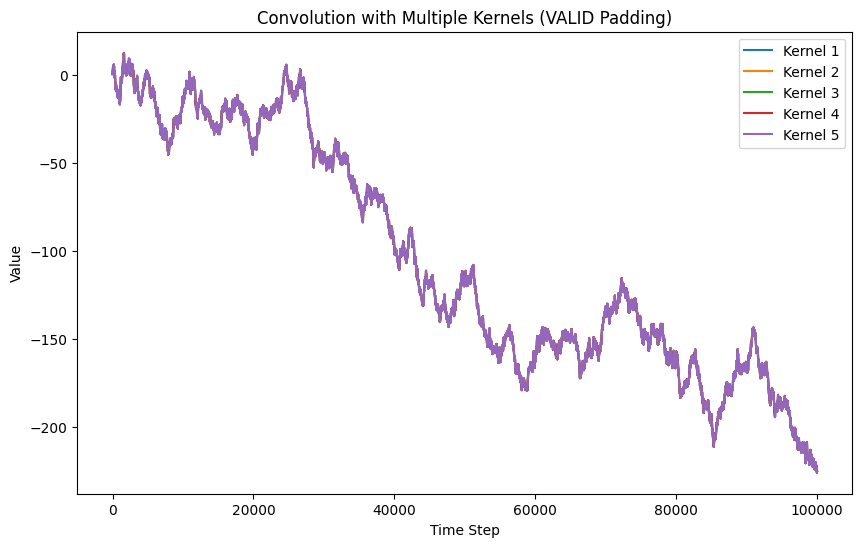

In [2]:
def convolve_time_series(time_series, kernel_functions):
    """
    Applies a set of kernel functions to a 1D time series using tf.nn.convolution
    with stride 1 and "VALID" padding.

    Args:
        time_series: A 1D numpy array representing the time series data.
        kernel_functions: A 2D numpy array where each row is a kernel function.
                         Shape: (num_kernel_functions, kernel_length).

    Returns:
        A TensorFlow tensor with shape [out_width, num_kernel_functions],
        where out_width = time_series_length - kernel_length + 1.
    """

    # 1. Prepare the data for tf.nn.convolution
    time_series = np.expand_dims(time_series, axis=(0, -1))  # Shape: (1, time_series_length, 1)
    kernel_functions = np.expand_dims(kernel_functions, axis=1)  # Shape: (num_kernel_functions, 1, kernel_length)
    kernel_functions = np.transpose(kernel_functions, (2, 1, 0))  # Shape: (kernel_length, 1, num_kernel_functions)

    time_series = tf.convert_to_tensor(time_series, dtype=tf.float32)
    kernel_functions = tf.convert_to_tensor(kernel_functions, dtype=tf.float32)

    # 2. Perform the convolution
    convolved = tf.nn.convolution(
        input=time_series,
        filters=kernel_functions,
        padding='VALID',
        strides=1,
    )

    # Remove the batch dimension
    convolved = tf.squeeze(convolved, axis=0)

    return convolved


# Example Usage
if __name__ == '__main__':
    # Example Time Series
    length = 100000
    sample_rate = 10
    time_series = tsa.symmetric_random_walk(length, sample_rate)

    # Example Kernel Functions
    num_kernel_functions = 5
    kernel_length = 10
    #kernel_functions = np.random.rand(num_kernel_functions, kernel_length)

    # Optionally, normalize the kernels
    #kernel_functions = kernel_functions / np.sum(kernel_functions, axis=1, keepdims=True)

    # Apply the convolution
    convolved_output = convolve_time_series(time_series, kernel_functions)

    # Print the shape of the output
    print("Shape of convolved output:", convolved_output.shape)  # Should be (91, 5)

    # Visualize (optional)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    for i in range(num_kernel_functions):
        plt.plot(convolved_output[:, i].numpy(), label=f"Kernel {i+1}")

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Convolution with Multiple Kernels (VALID Padding)")
    plt.legend()
    plt.show()

In [3]:
def subtract_2d_from_1d(arr_1d, arr_2d):
    """
    Subtracts each row of a 2D array from a 1D array.

    Args:
        arr_1d: A 1D numpy array of length n.
        arr_2d: A 2D numpy array of shape (m, n).

    Returns:
        A 2D numpy array of shape (m, n) where each row is the result of
        subtracting the corresponding row of arr_2d from arr_1d.
    """

    # Ensure that the arrays have compatible shapes
    if arr_1d.shape[-1] != arr_2d.shape[-1]: # same as `arr_1d.shape[0] != arr_2d.shape[1]` since arr_1d has only one axis
        raise ValueError("Arrays must have the same length along the last dimension")

    # Reshape arr_1d to be a 2D array with shape (1, n) so that broadcasting works correctly
    arr_1d_reshaped = arr_1d.reshape(1, -1)

    # Subtract using broadcasting
    result = arr_1d_reshaped - arr_2d

    return result

# Example Usage
if __name__ == '__main__':
    n = 5
    m = 3
    arr_1d = np.array([10, 20, 30, 40, 50])
    arr_2d = np.array([[1, 2, 3, 4, 5],
                       [6, 7, 8, 9, 10],
                       [11, 12, 13, 14, 15]])

    result = subtract_2d_from_1d(arr_1d, arr_2d)
    print(result)

[[ 9 18 27 36 45]
 [ 4 13 22 31 40]
 [-1  8 17 26 35]]
